# Binary Classification
-0 또는 1의 값으로 output을 하는 모델을 만들어 본다  
-Sigmoid 함수를 사용하는 Logistic Regression 방법으로 Classification하는 모델을 만든다

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## [1] Data

-위스콘신 대 유방암 진단 데이터(WDBC)
- 샘플수 : 569개
- Feature : 32개 (ID, 진단결과, 30개의 실측값) 

-유방암 데이터로 악성(M), 양성(B) 판단하는 모델 만들기

In [3]:
df_raw = pd.read_csv("./BreastCancer.csv") #csv(comma-separated values)파일 가져오기 (디렉토리 주소입력)
df_raw

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [4]:
#불필요한 Feature column 삭제 
x = df_raw.drop(["id", "Unnamed: 32"], axis=1)
# y값 column 삭제
x = x.drop(["diagnosis"], axis=1)

# y값 0과1로 변환
diag = { "M": 1, "B": 0}
y = df_raw["diagnosis"].replace(diag)

print(x.shape)
print(y.shape)
y.head()

(569, 30)
(569,)


0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

In [5]:
#학습데이터와 테스트데이터를 일정비율로 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=85)
print("x_train의 크기:{}",x_train.shape)
print("y_train의 크기:{}",y_train.shape)
print("x_testn의 크기:{}",x_test.shape)
print("y_test의 크기:{}",y_test.shape)

x_train의 크기:{} (455, 30)
y_train의 크기:{} (455,)
x_testn의 크기:{} (114, 30)
y_test의 크기:{} (114,)


In [6]:
#학습 데이터 Scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_tran = scaler.transform(x_train)


#학습 데이터 배치화 시키기 
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train_tran),
                                 torch.FloatTensor(y_train.values))

dataloader = data_utils.DataLoader(train_data, batch_size=128, shuffle=False)


#배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader):
    print(batch_idx)
    print(datas[0].shape)
    print(datas[1].shape)
    break

    
#테스트 데이터 Scaling    
x_test_tran = scaler.transform(x_test)


#테스트 데이터 텐서로 변환
x_test_tensor = torch.FloatTensor(x_test_tran)
y_test_tensor = torch.FloatTensor(y_test.values)


0
torch.Size([128, 30])
torch.Size([128])


## [2] Model

$$ H(X) = \frac{1}{1+e^{-W^T X}} $$

In [7]:

class LogisticRegression(torch.nn.Module):
        def __init__(self, input_size, output_size):
            super(LogisticRegression, self).__init__()
            self.input_size = input_size
            self.output_size = output_size
            self.linear = torch.nn.Linear(self.input_size, self.output_size)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear(input_tensor)
            output = self.sigmoid(linear1)
            return output
        

$$ cost(W) = -\frac{1}{m} \sum y \log\left(H(x)\right) + (1-y) \left( \log(1-H(x) \right) $$

In [8]:
#Hyper-parameter
input_size = 30
output_size = 1
learning_rate = 0.01
n_epochs = 200

#model 생성
model = LogisticRegression(input_size=input_size, output_size=output_size)

#손실함수 생성
criterion = torch.nn.BCELoss()  # 내부적으로 Softmax 함수가 적용됨
#Optimizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## [3] Training
-분류(Classification)에서는 성능 지표로 Accuracy를 사용
- Accuracy(정확도) = 정답수 / 전체 예측 횟수

In [9]:
## Running the model
train_loss = []
test_loss = []
train_accuracy=[]
test_accuracy=[]

for epoch in range(n_epochs+1):
    for idx, (x_batch, y_batch) in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_pred = y_pred.reshape(-1)

        loss_train = criterion(y_pred.squeeze(), y_batch)
        
        #정답을 맞춘 예측값을 카운트
        
        prediction = [1 if x > 0.5 else 0 for x in y_pred.data.numpy()]
        correct = (prediction == y_batch.numpy()).sum()
        
        loss_train.backward()
        optimizer.step()
        
        #Validation
        model.eval()
        y_test_pred = model(x_test_tensor)
        loss_test = criterion(y_test_pred.squeeze(), y_test_tensor)
        prediction_test = [1 if x > 0.5 else 0 for x in y_test_pred.data.numpy()]
        correct_test = (prediction_test == y_test_tensor.data.numpy()).sum()


    
    accuracy_train = (100 * correct / len(prediction))
    accuracy_test = (100 * correct_test / len(prediction_test))
    
    train_loss.append(loss_train.data)
    test_loss.append(loss_test.data)
    train_accuracy.append(accuracy_train)
    test_accuracy.append(accuracy_test)    
    print(f'epoch:{epoch}, Loss_train:{train_loss[-1]:.2f}, Accuracy_train:{ train_accuracy[-1]:.2f}, Loss_test:{test_loss[-1]:.2f}, Accuracy_test:{test_accuracy[-1]:.2f}')
          

epoch:0, Loss_train:0.59, Accuracy_train:70.42, Loss_test:0.60, Accuracy_test:75.44
epoch:1, Loss_train:0.53, Accuracy_train:84.51, Loss_test:0.55, Accuracy_test:85.09
epoch:2, Loss_train:0.48, Accuracy_train:85.92, Loss_test:0.50, Accuracy_test:89.47
epoch:3, Loss_train:0.45, Accuracy_train:91.55, Loss_test:0.47, Accuracy_test:90.35
epoch:4, Loss_train:0.42, Accuracy_train:95.77, Loss_test:0.44, Accuracy_test:91.23
epoch:5, Loss_train:0.39, Accuracy_train:97.18, Loss_test:0.41, Accuracy_test:92.98
epoch:6, Loss_train:0.37, Accuracy_train:97.18, Loss_test:0.39, Accuracy_test:92.98
epoch:7, Loss_train:0.35, Accuracy_train:97.18, Loss_test:0.38, Accuracy_test:92.98
epoch:8, Loss_train:0.34, Accuracy_train:97.18, Loss_test:0.36, Accuracy_test:92.98
epoch:9, Loss_train:0.32, Accuracy_train:97.18, Loss_test:0.35, Accuracy_test:92.98
epoch:10, Loss_train:0.31, Accuracy_train:97.18, Loss_test:0.33, Accuracy_test:92.98
epoch:11, Loss_train:0.30, Accuracy_train:95.77, Loss_test:0.32, Accuracy_t

epoch:101, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:102, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:103, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:104, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:105, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:106, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:107, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:108, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:109, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:110, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:111, Loss_train:0.12, Accuracy_train:97.18, Loss_test:0.14, Accuracy_test:92.98
epoch:112, Loss_train:0.12, Accuracy_train:97.18, Loss

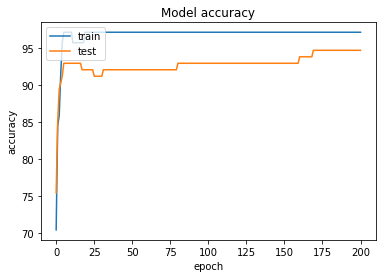

In [10]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

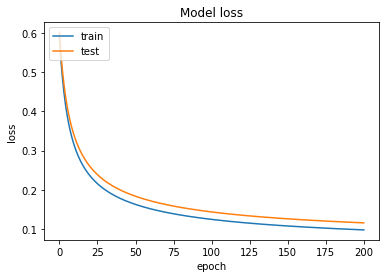

In [11]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()